<a href="https://colab.research.google.com/github/amitav710/SAiDl/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning

Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import math
from tensorflow.keras import layers
from tensorflow.keras.layers import (
 Conv2D,
 BatchNormalization,
 Dense,
 MaxPool2D,
 Flatten,
 Dropout,
 Add,
 ReLU
)

Loading and formatting datasets

In [2]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV99SBV/stl10-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV99SBV/stl10-test.tfrecord


  0%|          | 0/8000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV99SBV/stl10-unlabelled.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [3]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[140, 174, 166], [136, 170, 165], [133, 170,...",6
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[171, 183, 180], [173, 184, 181], [174, 185,...",8
4,"[[[86, 74, 61], [114, 106, 92], [129, 119, 96]...",7


In [4]:
x_train=[]
y_train=[]
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(5000, 96, 96, 3)

In [5]:
y_train = pd.get_dummies(y_train)
y_train.shape

(5000, 10)

In [6]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)

In [7]:
x_test.shape

(8000, 96, 96, 3)

In [8]:
y_test.shape

(8000, 10)

Image augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [10]:
training_set = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

In [11]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

Making the CNN

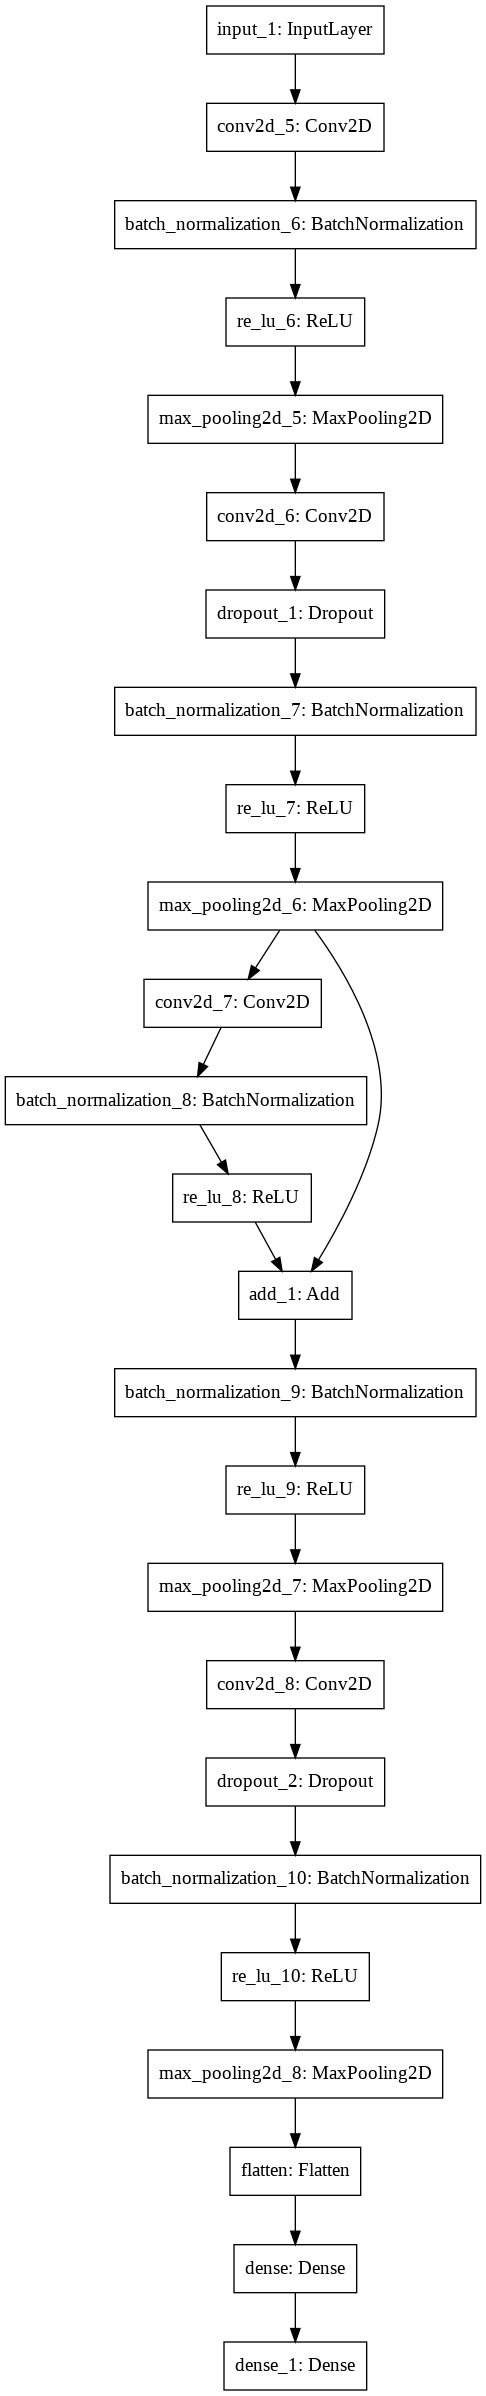

In [12]:
shape=(96,96,3)
input=layers.Input(shape)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x=(Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy1=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy2=x
x = Add()([x_copy1,x_copy2])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy3=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy4=x
x = Add()([x_copy3,x_copy4])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)
x = (Flatten())(x)
x = (Dense(128, activation = 'relu'))(x)
output = (Dense(units=10,activation = 'softmax'))(x)

cnn = tf.keras.Model(inputs=input, outputs=output)
plot_model(cnn)

In [20]:
stop = EarlyStopping(patience=25)

In [14]:
"""initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.75
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate, 
  decay_steps, 
  decay_rate,
  staircase=True
)"""

'initial_learning_rate = 0.01\ndecay_steps = 10.0\ndecay_rate = 0.75\nlearning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(\n  initial_learning_rate, \n  decay_steps, \n  decay_rate,\n  staircase=True\n)'

Training the CNN

In [15]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0004)

In [16]:
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
checkpoint_filepath = '/Desktop/CV'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [17]:
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 96, 96, 96)   2688        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 96, 96, 96)   384         conv2d_5[0][0]                   
__________________________________________________________________________________________________
re_lu_6 (ReLU)                  (None, 96, 96, 96)   0           batch_normalization_6[0][0]      
______________________________________________________________________________________________

In [22]:
history=cnn.fit(x=training_set, validation_data=test_set, epochs= 120, batch_size=32, callbacks=[stop, model_checkpoint_callback])

Epoch 1/120
157/157 [==============================] - 32s 100ms/step - loss: 1.9503 - accuracy: 0.2872 - val_loss: 1.6359 - val_accuracy: 0.3677
Epoch 2/120
157/157 [==============================] - 15s 99ms/step - loss: 1.6019 - accuracy: 0.3902 - val_loss: 1.5275 - val_accuracy: 0.4325
Epoch 3/120
157/157 [==============================] - 15s 98ms/step - loss: 1.5140 - accuracy: 0.4328 - val_loss: 1.4329 - val_accuracy: 0.4723
Epoch 4/120
157/157 [==============================] - 15s 98ms/step - loss: 1.3945 - accuracy: 0.4786 - val_loss: 1.3083 - val_accuracy: 0.5190
Epoch 5/120
157/157 [==============================] - 15s 98ms/step - loss: 1.3523 - accuracy: 0.4936 - val_loss: 1.2783 - val_accuracy: 0.5362
Epoch 6/120
157/157 [==============================] - 15s 98ms/step - loss: 1.2897 - accuracy: 0.5140 - val_loss: 1.2955 - val_accuracy: 0.5241
Epoch 7/120
157/157 [==============================] - 15s 98ms/step - loss: 1.2360 - accuracy: 0.5440 - val_loss: 1.1792 - val_a

Accuracy History

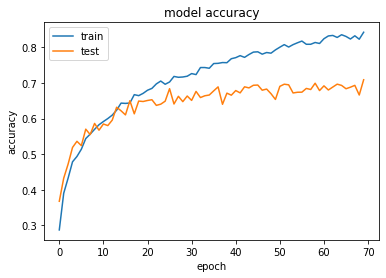

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

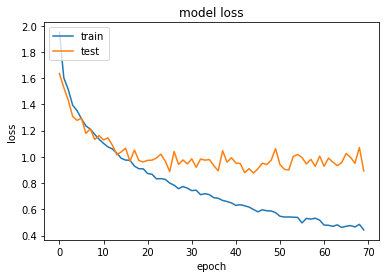

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
cnn.save(checkpoint_filepath)

INFO:tensorflow:Assets written to: /Desktop/CV/assets


INFO:tensorflow:Assets written to: /Desktop/CV/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
